In [ ]:
!pip install sentence_transformers --quiet

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, precision_recall_fscore_support
import math
from imblearn.under_sampling import RandomUnderSampler

In [2]:
syn = pd.read_csv('/kaggle/input/real-fake-data/synthetic_data (1).csv')
real = pd.read_csv('/kaggle/input/real-fake-data/train (1).csv')

In [3]:
# Labelling real and synthetic labels
syn['Label'] = 1
real['Label'] = 0

In [4]:
real.rename(columns={'cleaned_text':'review_text'},inplace=True)
combined_df = pd.concat([real[['review_text', 'Label']], syn[['review_text', 'Label']]], axis=0)

### Balancing the real and synthetic data

In [5]:
X = combined_df['review_text']
y = combined_df['Label']
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X.values.reshape(-1, 1), y)
balanced_df = pd.DataFrame({'review_text': X_resampled.flatten(), 'Label': y_resampled})
balanced_df = balanced_df.reset_index(drop=True)
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv('classification_data.csv',index = False)

In [6]:
df.head()

,review_text,Label
0,this is the third time ive purchase this for m...,0
1,saw nothing and felt nothing,0
2,excellent,1
3,excellent product,1
4,great product,1


### Dataset preparation for trainig

In [7]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
def train_model(model, data_loader, optimizer, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

In [9]:
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs[0], dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), precision_recall_fscore_support(actual_labels, predictions, average='binary')

In [10]:
reviews = df['review_text'].values
labels = df['Label'].values 
train_texts, val_texts, train_labels, val_labels = train_test_split(reviews, labels, test_size=0.2, random_state=42)


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 256

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
train_dataset = ReviewDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = ReviewDataset(val_texts, val_labels, tokenizer, max_len)

train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16)

In [13]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Model training

In [14]:
epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    train_model(model, train_data_loader, optimizer, device)
    accuracy, (precision, recall, f1, _) = evaluate_model(model, val_data_loader, device)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

Epoch 1/20
Accuracy: 0.8691
Precision: 0.8471
Recall: 0.9050
F1-score: 0.8751
Epoch 2/20
Accuracy: 0.8524
Precision: 0.8033
Recall: 0.9385
F1-score: 0.8657
Epoch 3/20
Accuracy: 0.8760
Precision: 0.8767
Recall: 0.8789
F1-score: 0.8778
Epoch 4/20
Accuracy: 0.8798
Precision: 0.8545
Recall: 0.9193
F1-score: 0.8857
Epoch 5/20
Accuracy: 0.8685
Precision: 0.8307
Recall: 0.9298
F1-score: 0.8775
Epoch 6/20


KeyboardInterrupt: 

Although epochs are given 20, we stopped it midway as the perfromance of classifer was quite good from inital epochs. So, we see that classifier is able to classify these

In [15]:
# Saving the model
torch.save(model.state_dict(), 'bert_review_classifier.pth')

In [25]:
real_reviews = df[df['Label'] == 0]['review_text'].values
synthetic_reviews = df[df['Label'] == 1]['review_text'].values

### Finding the semantic similarity

In [35]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def preprocess_reviews(reviews):
    preprocessed = []
    for review in reviews:
        if isinstance(review, str):
            preprocessed.append(review)
        elif isinstance(review, (int, float)):
            if not np.isnan(review):
                preprocessed.append(str(review))
        elif review is not None:
            preprocessed.append(str(review))
    return preprocessed

def analyze_semantic_similarity(real_reviews, synthetic_reviews):
    # Preprocess reviews
    real_reviews = preprocess_reviews(real_reviews)
    synthetic_reviews = preprocess_reviews(synthetic_reviews)

    if not real_reviews or not synthetic_reviews:
        print("Error: No valid reviews after preprocessing.")
        return

    # Load pre-trained model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Encode reviews
    real_embeddings = model.encode(real_reviews)
    synthetic_embeddings = model.encode(synthetic_reviews)

    # Calculate similarity matrices
    real_sim = cosine_similarity(real_embeddings)
    synthetic_sim = cosine_similarity(synthetic_embeddings)
    cross_sim = cosine_similarity(real_embeddings, synthetic_embeddings)

    # Plot similarity distributions
    plt.figure(figsize=(10, 6))
    plt.hist(real_sim[np.triu_indices(len(real_sim), k=1)], bins=30, alpha=0.5, label='Real-Real')
    plt.hist(synthetic_sim[np.triu_indices(len(synthetic_sim), k=1)], bins=30, alpha=0.5, label='Synthetic-Synthetic')
    plt.hist(cross_sim.flatten(), bins=30, alpha=0.5, label='Real-Synthetic')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Semantic Similarities')
    plt.legend()
    plt.show()

    # Print summary statistics
    print(f"Mean Real-Real Similarity: {np.mean(real_sim[np.triu_indices(len(real_sim), k=1)]):.4f}")
    print(f"Mean Synthetic-Synthetic Similarity: {np.mean(synthetic_sim[np.triu_indices(len(synthetic_sim), k=1)]):.4f}")
    print(f"Mean Real-Synthetic Similarity: {np.mean(cross_sim):.4f}")


Batches:   0%|          | 0/248 [00:00<?, ?it/s]

Batches:   0%|          | 0/249 [00:00<?, ?it/s]

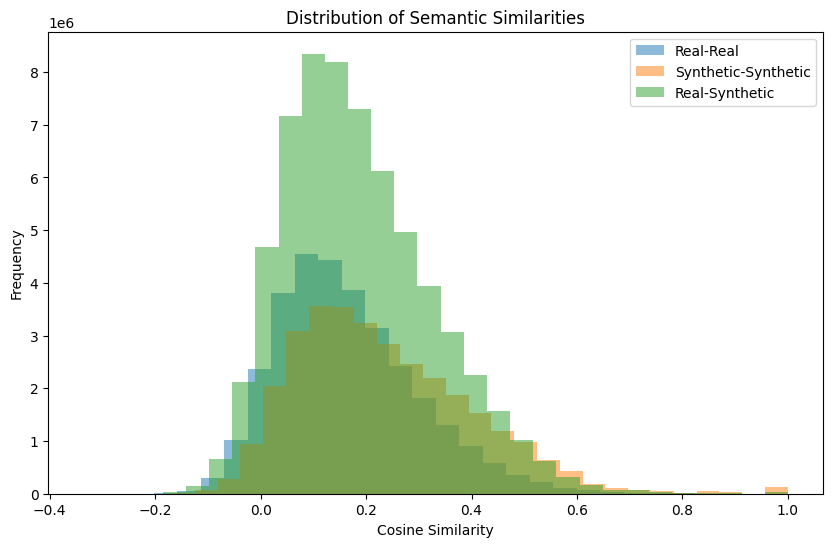

Mean Real-Real Similarity: 0.1646
Mean Synthetic-Synthetic Similarity: 0.2348
Mean Real-Synthetic Similarity: 0.1878


In [36]:
analyze_semantic_similarity(real_reviews, synthetic_reviews)